In [19]:
'''
Here, we plot PDGrapher performance as a function of the forward data (ablating forward data and seeing whether it stays moreless consistent)
Random splitting. Chemical and Genetic datasets
'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
import sys
sys.path.append('../../')
from constants import *
import os
import numpy as np
from scipy import stats


outdir = 'processed'
os.makedirs(outdir, exist_ok = True)
performance = {}

def add_to_performance(df, cell_line, method_name, performance):
    # Populate the dictionary
    for index, row in df.iterrows():
        metric = row['Metric']
        if metric == 'ranking score':
            metric = 'rankings'
        if cell_line not in performance:
            performance[cell_line] = {}
            
        if metric not in performance[cell_line]:
            performance[cell_line][metric] = {method_name: []}

        values = [row['Fold 1'], row['Fold 2'], row['Fold 3'], row['Fold 4'], row['Fold 5']]
        performance[cell_line][metric][method_name] = values
    return performance

In [20]:
performance = {}
for cell_line in ['A549', 'BT20', 'MCF7', 'MDAMB231', 'PC3', 'VCAP']:

    #Loads with/without forward data
    df_no_forward = pd.read_csv('../../../results_metrics_aggregated_bme/no_forward/chemical/{}_drugpred_no_forward_best.csv'.format(cell_line))
    df_original = pd.read_csv('../../../results_metrics_aggregated_bme/perturbagen_pred/PDgrapher/within/chemical/val/{}_drugpred_within_best.csv'.format(cell_line))

    #Selects only test
    df_no_forward = df_no_forward[df_no_forward['Set'] == 'Test']
    df_original = df_original[df_original['Set'] == 'Test']


    performance = add_to_performance(df_no_forward, cell_line, 'PDGrapher - No forward data', performance)
    performance = add_to_performance(df_original, cell_line, 'PDGrapher', performance)
   

In [21]:
performance['A549']['recall@1'].keys()

dict_keys(['PDGrapher - No forward data', 'PDGrapher'])

In [22]:
cell_line_to_cancer_type = {
    'A549': 'Lung-A549',
    'A375': 'Skin-A375',
    'BT20': 'Breast-BT20',
    'HELA': 'Cervix-HELA',
    'HT29': 'Colon-HT29',
    'MCF7': 'Breast-MCF7',
    'MDAMB231': 'Breast-MDAMB231',
    'PC3': 'Prostate-PC3',
    'VCAP': 'Prostate-VCAP'
}

## Panel proportion of partially accurate samples

/tmp/ipykernel_1778057/3004723960.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


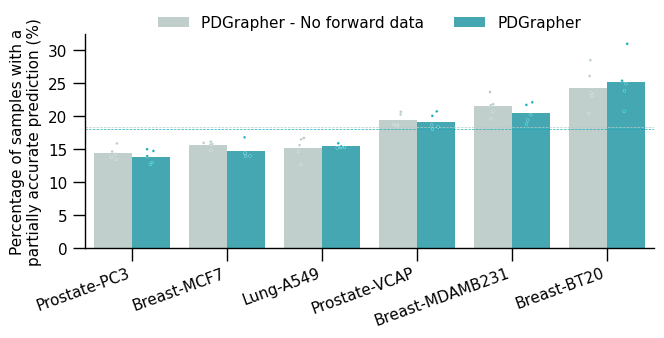

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'percentage of samples with partially accurate predictions'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()


#Rename cell lines
df['Cancer Type'] = df['Cell Line'].map(cell_line_to_cancer_type)
df_mean['Cancer Type'] = df_mean['Cell Line'].map(cell_line_to_cancer_type)
# Replace x-axis labels with cancer types
df['Cell Line'] = df['Cancer Type']
df_mean['Cell Line'] = df_mean['Cancer Type']



# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'PDGrapher - No forward data': '#B8CCC9',
    'PDGrapher': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - No forward data', 'PDGrapher']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)
    plt.xticks(rotation=20, ha="right")
    plt.subplots_adjust(bottom = 0.25)
    plt.ylabel('Percentage of samples with a\npartially accurate prediction (%)')
    plt.savefig(osp.join(outdir, 'panel_partially_accurate_pred.pdf'))
    plt.show()




## Panel rankings

/tmp/ipykernel_1778057/3136036690.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


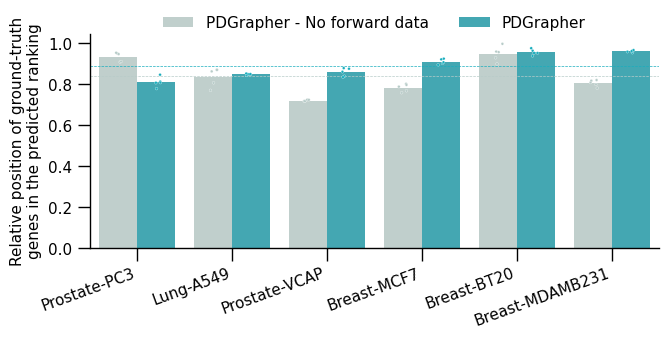

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'rankings'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()


#Rename cell lines
df['Cancer Type'] = df['Cell Line'].map(cell_line_to_cancer_type)
df_mean['Cancer Type'] = df_mean['Cell Line'].map(cell_line_to_cancer_type)
# Replace x-axis labels with cancer types
df['Cell Line'] = df['Cancer Type']
df_mean['Cell Line'] = df_mean['Cancer Type']


# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'PDGrapher - No forward data': '#B8CCC9',
    'PDGrapher': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - No forward data', 'PDGrapher']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)
    plt.xticks(rotation=20, ha="right")
    plt.subplots_adjust(bottom = 0.25)
    plt.ylabel('Relative position of ground-truth\ngenes in the predicted ranking')
    plt.savefig(osp.join(outdir, 'panel_ranking.pdf'))
    plt.show()




## Panels recall

/tmp/ipykernel_1778057/134056550.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


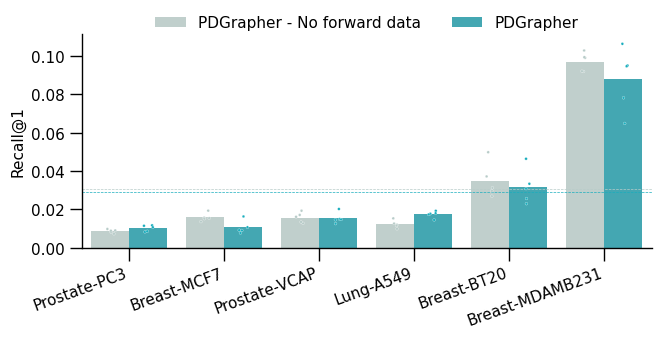

/tmp/ipykernel_1778057/134056550.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


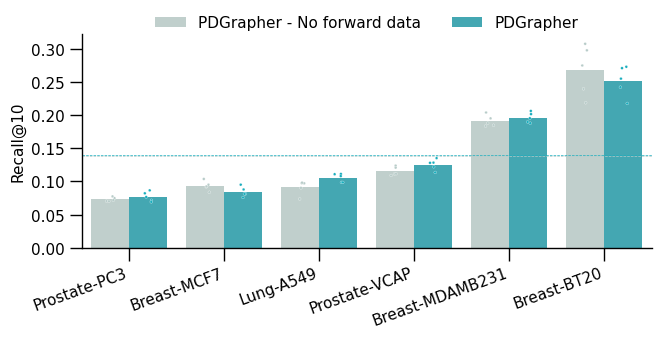

/tmp/ipykernel_1778057/134056550.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


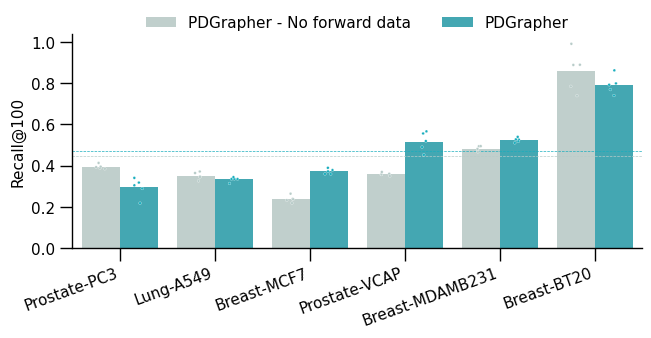

/tmp/ipykernel_1778057/134056550.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


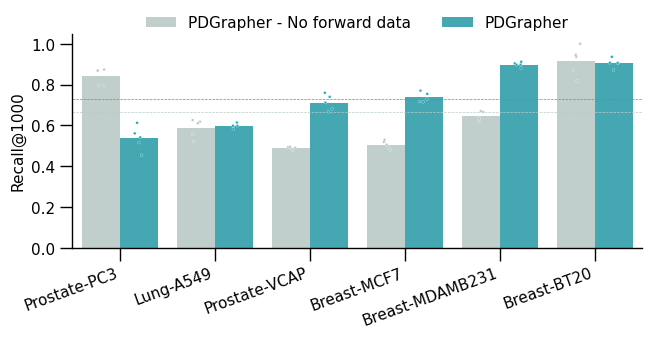

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'recall@1'

for metric in ['recall@1', 'recall@10', 'recall@100', 'recall@1000']:
    data = []
    for cellline, metrics in performance.items():
        if metric in metrics:
            for method, values in metrics[metric].items():
                for value in values:
                    data.append([cellline, method, value])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

    # Calculate the mean 'rankings' for each cell line and method
    df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

    # Order cell lines based on values for PDGrapher
    pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher'].sort_values(by=metric)
    ordered_cell_lines = pdgrapher_means['Cell Line']

    # Reorder the DataFrame based on ordered cell lines
    df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
    df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)


    #Rename cell lines
    df['Cancer Type'] = df['Cell Line'].map(cell_line_to_cancer_type)
    df_mean['Cancer Type'] = df_mean['Cell Line'].map(cell_line_to_cancer_type)
    # Replace x-axis labels with cancer types
    df['Cell Line'] = df['Cancer Type']
    df_mean['Cell Line'] = df_mean['Cancer Type']

    # Define a color palette that matches the existing figures
    palette = {
        'PDGrapher - No forward data': '#B8CCC9',
        'PDGrapher': '#1AAEBE',
    }

    # Define the order of methods
    method_order = ['PDGrapher - No forward data', 'PDGrapher']

    with sns.plotting_context(plotting_context):
        # Initialize the plot
        fig, ax = plt.subplots(figsize=(7.35, 3.4))

        # Create a bar plot for each method
        sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

        # Overlay individual data points
        sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





        # Add horizontal lines for the overall mean ranking for each method
        for method in method_order:
            overall_mean = df[df['Method'] == method][metric].mean()
            plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

        # Remove title
        plt.title('')
        plt.ylim

        # Remove X-axis label
        plt.xlabel('')
        sns.despine()

        # Adjust legend to only include the bars and place it at the top
        handles, labels = plt.gca().get_legend_handles_labels()
        bar_handles = handles[:len(method_order)]
        bar_labels = labels[:len(method_order)]
        plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)
        plt.xticks(rotation=20, ha="right")
        plt.subplots_adjust(bottom = 0.25)
        plt.ylabel(metric.capitalize())
        plt.savefig(osp.join(outdir, 'panel_{}.pdf'.format(metric)))
        plt.show()




## Aggregated recall@k

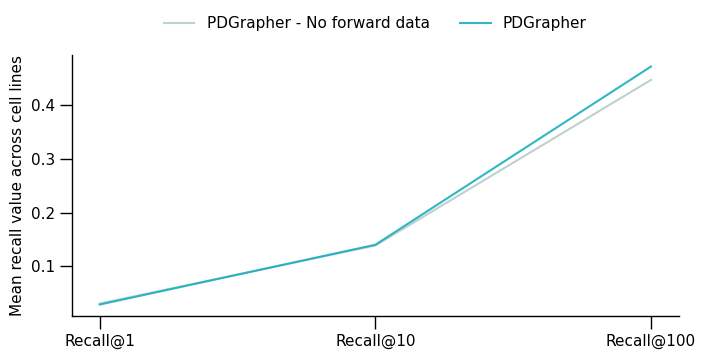

In [26]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty list to store the data
data = []

# Iterate over the performance dictionary to extract all recall metrics
for cellline, metrics in performance.items():
    for metric in ['recall@1', 'recall@10', 'recall@100']:
        if metric in metrics:
            for method, values in metrics[metric].items():
                for value in values:
                    data.append([cellline, metric, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Metric', 'Method', 'Value'])

# Convert the 'Value' column to numeric to avoid any conversion issues
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# Calculate the mean for each method and metric across all cell lines
df_mean = df.groupby(['Metric', 'Method'])['Value'].mean().reset_index()



#Color palette
palette = {
    'PDGrapher - No forward data': '#B8CCC9',
    'PDGrapher': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - No forward data', 'PDGrapher']
df_mean['Metric'] = [e.capitalize() for e in df_mean['Metric']]

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a line plot for each method showing the mean across all cell lines
    sns.lineplot(data=df_mean, x='Metric', y='Value', hue='Method', palette=palette, hue_order=method_order, markers=True, dashes=False, alpha=0.9)

    # Remove X-axis label
    plt.xlabel('')

    sns.despine()

    # Adjust legend to place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    line_handles =  handles[:len(method_order)]
    line_labels = labels[:len(method_order)]
    plt.legend(line_handles, line_labels, bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=4, frameon=False, title=None)
    # plt.subplots_adjust(top=0.9)
    plt.subplots_adjust(right=0.95)
    # plt.xticks(rotation=20, ha="right")
    plt.ylabel('Mean recall value across cell lines')
    plt.savefig(osp.join(outdir, 'panel_aggregated_mean_recall_metrics.pdf'))
    plt.show()
